In [1]:
using AbstractTrees,
      BenchmarkTools,
      CairoMakie,
      CliqueTrees,
      DataFrames,
      EinExprs,
      OMEinsum,
      OMEinsumContractionOrders,
      Random,
      SparseArrays,
      Yao

using OMEinsum: get_size_dict, LeafString
using Yao.YaoToEinsum: TensorNetwork

include("reading_qflex_qasm_yao.jl")
using .YaoQASMReader: yaocircuit_from_qasm

Random.seed!(0)

┌ Warning: Package GraphMakie not found in current path. It is needed to plot `EinExpr`s with `Makie`.
│ - Run `import Pkg; Pkg.add("GraphMakie")` or `]add GraphMakie` to install the GraphMakie package, then restart julia.
└ @ EinExprsMakieExt ~/Source/git/EinExprs.jl/ext/EinExprsMakieExt.jl:7


TaskLocalRNG()

In [2]:
function make(::Type{TensorNetwork}, circuit)
    n = nqubits(circuit)
    
    network = yao2einsum(circuit;
        initial_state = Dict(zip(1:n, zeros(Int, n))),
        final_state = Dict(zip(1:n, zeros(Int, n))),
        optimizer = nothing,
    )
    
    indices = network.code.ixs
    tensors = network.tensors
    permutation = randperm(length(unique(vcat, indices)))
    
    for index in indices
        index .= permutation[index]
    end
    
    return network
end

function make(::Type{SizedEinExpr}, circuit)
    n = nqubits(circuit)
    
    network = yao2einsum(circuit;
        initial_state = Dict(zip(1:n, zeros(Int, n))),
        final_state = Dict(zip(1:n, zeros(Int, n))),
        optimizer = nothing,
    )
    
    query = network.code.iy
    indices = network.code.ixs
    tensors = network.tensors
    permutation = randperm(length(unique(vcat, indices)))
    
    query .= permutation[query]
    
    for index in indices
        index .= permutation[index]
    end
    
    args = map(indices) do i
        return EinExpr(i)
    end
    
    size = get_size_dict(indices, tensors)
    return SizedEinExpr(EinExpr(query, args), size)
end

function solve(network::TensorNetwork, optimizer)
    return optimize_code(network, optimizer, MergeVectors())
end

function solve(network::SizedEinExpr, optimizer)
    return einexpr(optimizer, network)
end

function score(network::TensorNetwork)
    tree = network.code
    size = get_size_dict(getixsv(tree), network.tensors)
    
    m = 0; index = Dict{Int, Int}(); weights = Float64[]; order = Int[]
    
    for node in PreOrderDFS(tree)
        if !isa(node, LeafString)
            for label in node.eins.iy
                if !haskey(index, label)
                    index[label] = m += 1
                    push!(weights, log2(size[label]))
                end
            end
        else
            for string in eachsplit(node.str, "∘")
                label = parse(Int, string)
                
                if !haskey(index, label)
                    index[label] = m += 1
                    push!(weights, log2(size[label]))
                end
            end
        end
    end
    
    n = 0; p = 1; colptr = Int[1]; rowval = Int[]; nzval = Int[]
    
    for leaf in Leaves(tree)
        for string in eachsplit(leaf.str, "∘")
            label = parse(Int, string)
            i = index[label]
            p += 1; push!(rowval, i); push!(nzval, 1)
        end
        
        n += 1; push!(colptr, p)
    end
    
    hypergraph = SparseMatrixCSC(m, n, colptr, rowval, nzval)
    hypergraph = copy(transpose(hypergraph))
    dualgraph = hypergraph' * hypergraph
    
    return treewidth(weights, dualgraph; alg=m:-1:1)
end

function score(network::SizedEinExpr{L}) where {L}
    tree = network.path
    size = network.size

    m = 0; index = Dict{L, Int}(); weights = Float64[]; order = Int[]
    
    for node in PreOrderDFS(tree)
        for label in head(node)
            if !haskey(index, label)
                index[label] = m += 1
                push!(weights, log2(size[label]))
            end
        end
    end
    
    n = 0; p = 1; colptr = Int[1]; rowval = Int[]; nzval = Int[]
    
    for leaf in Leaves(tree)
        for label in head(leaf)
            i = index[label]
            p += 1; push!(rowval, i); push!(nzval, 1)
        end
        
        n += 1; push!(colptr, p)
    end
        
    hypergraph = SparseMatrixCSC(m, n, colptr, rowval, nzval)
    hypergraph = copy(transpose(hypergraph))
    dualgraph = hypergraph' * hypergraph
    
    return treewidth(weights, dualgraph; alg=m:-1:1)
end

score (generic function with 2 methods)

In [3]:
trials = 10
widths = Vector{Float64}(undef, trials)
times = Vector{Float64}(undef, trials)

labels = [
    "EinExprs (Greedy)",
    "OMEinsum (GreedyMethod)",
    "CliqueTrees (MF)",
    "CliqueTrees (MMD)",
]

triples = (
    (1, SizedEinExpr, Greedy()),
    (2, TensorNetwork, GreedyMethod()),
    (3, TensorNetwork, Treewidth(; alg=MF())),
    (4, TensorNetwork, Treewidth(; alg=MMD())),
)

dataframe = DataFrame(
    width=Float64[], # tree width
    time=Float64[],  # run time
    file = String[], # circuit file
    label=Int[],     # label
)

for file in readdir("circuits")
    if endswith(file, ".txt")
        println(file)
        println()
        
        path = joinpath(@__DIR__, "circuits", file)
        circuit = yaocircuit_from_qasm(path)
                
        for (label, T, optimizer) in triples
            network = make(T, circuit)
            
            for trial in 1:trials
                widths[trial] = score(solve(network, optimizer))
                times[trial] = @elapsed solve(network, optimizer)
            end
            
            time = minimum(times)
            width = minimum(widths)
            
            println("$(labels[label])")
            println("width: $width")
            println("time: $time")
            println()
            
            push!(dataframe, (
                width,
                time,
                file,
                label,
            ))
        end
    end
end

bristlecone_48_1-16-1_0.txt

EinExprs (Greedy)
width: 17.0
time: 0.088153959

OMEinsum (GreedyMethod)
width: 19.0
time: 0.007932125

CliqueTrees (MF)
width: 15.0
time: 0.006575834

CliqueTrees (MMD)
width: 18.0
time: 0.006553958

bristlecone_48_1-20-1_0.txt

EinExprs (Greedy)
width: 21.0
time: 0.124514084

OMEinsum (GreedyMethod)
width: 26.0
time: 0.010257875

CliqueTrees (MF)
width: 16.0
time: 0.008113625

CliqueTrees (MMD)
width: 16.0
time: 0.007968083

bristlecone_48_1-24-1_0.txt

EinExprs (Greedy)
width: 29.0
time: 0.166261333

OMEinsum (GreedyMethod)
width: 33.0
time: 0.012749459

CliqueTrees (MF)
width: 22.0
time: 0.00979125

CliqueTrees (MMD)
width: 24.0
time: 0.009570042

bristlecone_48_1-32-1_0.txt

EinExprs (Greedy)
width: 42.0
time: 0.254110875

OMEinsum (GreedyMethod)
width: 53.0
time: 0.017915958

CliqueTrees (MF)
width: 29.0
time: 0.013076625

CliqueTrees (MMD)
width: 33.0
time: 0.01280675

bristlecone_48_1-40-1_0.txt

EinExprs (Greedy)
width: 55.0
time: 0.37936275

OMEin

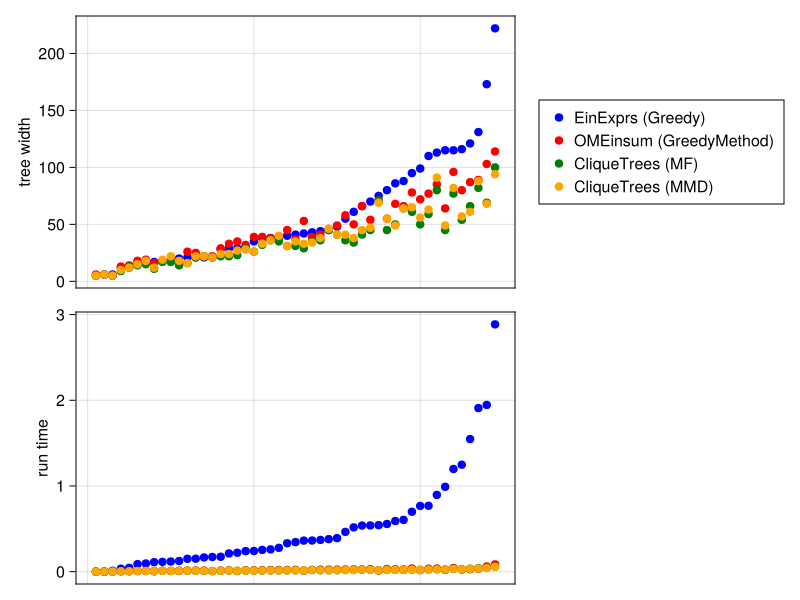

In [18]:
figure = Figure(size = (450, 250))

width1 = dataframe.width[dataframe.label .== 1]
width2 = dataframe.width[dataframe.label .== 2]
width3 = dataframe.width[dataframe.label .== 3]
width4 = dataframe.width[dataframe.label .== 4]
perm = sortperm(width1)
axis = Axis(figure[1, 1], ylabel = "tree width", xticksvisible = false, xticklabelsvisible = false)
scatter!(axis, width1[perm], color = :blue)
scatter!(axis, width2[perm], color = :red)
scatter!(axis, width3[perm], color = :green)
scatter!(axis, width4[perm], color = :orange)

time1 = dataframe.time[dataframe.label .== 1]
time2 = dataframe.time[dataframe.label .== 2]
time3 = dataframe.time[dataframe.label .== 3]
time4 = dataframe.time[dataframe.label .== 4]
perm = sortperm(time1)
axis = Axis(figure[2, 1], ylabel = "run time", xticksvisible = false, xticklabelsvisible = false)
plot1 = scatter!(axis, time1[perm], color = :blue)
plot2 = scatter!(axis, time2[perm], color = :red)
plot3 = scatter!(axis, time3[perm], color = :green)
plot4 = scatter!(axis, time4[perm], color = :orange)

Legend(
    figure[1, 2],
    [plot1, plot2, plot3, plot4],
    labels,
)

save("local.png", figure)
figure